In [1]:
import cantera as ct    # import cantera
import math             # import math (sqrt, exp, etc.)
from scipy.integrate import solve_ivp  # solves ODE (initial value problems)
import scipy.integrate as integrate
import matplotlib.pyplot as plt      # does matlab-like plotting
import numpy as np                   

In [2]:
gas= ct.Solution('chem.cti')

In [3]:
gas.int_energy_mass

213813912.33789644

## Parameters of the engine 

In [4]:
class engine:
    
    def __init__(self,L,B,S,cr,N_in,N_ex,itheta_op,itheta_cl,etheta_op,etheta_cl,rf_in,rf_ex):
        self.L=L
        self.B=B
        self.S=S
        self.R=S/2.0
        self.cr=cr
        self.D_in=0.45*B
        self.D_ex=0.37*B
        self.D_va=0.25*B
        self.N_in=N_in
        self.N_ex=N_ex
        self.itheta_op=itheta_op
        self.itheta_cl=itheta_cl
        self.etheta_op=etheta_op
        self.etheta_cl=etheta_cl
        self.rf_in=rf_in
        self.rf_ex=rf_ex
        
    def clearance_vol(self):
        Ap = (math.pi*self.B**2.0)/4.0
        return self.S*Ap/(self.cr-1)
    
    def piston_area(self):
        return (math.pi*self.B**2.0)/4.0
        
        
    def intake_max_area(self):
        Av_in= (math.pi*self.D_in**2.0)/4.0
        Avs_in=(math.pi*self.D_va**2.0)/4.0
        return Av_in-Avs_in
        
    def exhaust_max_area(self):
        Av_ex=(math.pi*self.D_ex**2.0)/4.0
        Avs_ex=(math.pi*self.D_va**2.0)/4.0
        return Av_ex-Avs_ex
    
    def intake_valve_area(self,theta):
        theta_shift =360 
        t=(theta+theta_shift)%720
        
        to_rel = self.itheta_op+theta_shift
        tc_rel = self.itheta_cl+theta_shift
        
        y=self.intake_max_area()*0.5*(
        np.tanh((t-to_rel)/self.rf_in)-
        np.tanh((t-tc_rel)/self.rf_in) )
        return y
    
    def exhaust_valve_area(self,theta):
        theta_shift =360 
        t=(theta+theta_shift)%720
        
        to_rel = self.etheta_op+theta_shift
        tc_rel = self.etheta_cl+theta_shift
        
        y=self.exhaust_max_area()*0.5*(
        np.tanh((t-to_rel)/self.rf_ex)-
        np.tanh((t-tc_rel)/self.rf_ex) )
        return y


In [5]:
hcci=engine(145.54,82.0,90.4,16.7,2,2,0,220,540,720,20,20)

In [6]:
hcci.exhaust_valve_area(79)

0.0

## Function for solving governing equation

In [8]:
def engine_rhs(theta,y,gas,hcci,p0,T0,dtheta_dt):
    
    dy = np.zeros(np.size(y))
    
    # mass in and out 
    #### find Mach number 
    Runi= 8.314
    pb=gas.P
    gam = gas.cp_mass/gas.cv_mass
    rho = y[0]
    T= y[1]
    massfrac = y[2:]
    
    
    # rho equation 
    p_fac_in = (p0/pb)**((gam-1.)/gam)
    
    M_in =min(1.,math.sqrt((2.*max(p_fac_in,0.))/(gam-1.))) # intlet mach 
    tau_in = M_in*math.sqrt(gam)*math.pow((1.+0.5*(gam-1.)*M_in**2.0),(-(gam+1)/(2*(gam-1))))
    mf_in=p0*tau_in/math.sqrt(Runi*t0)
    Av_in = hcci.intake_valve_area(theta)
    mt_in=Av_in*mf_in*hcci.N_in # cd=1
    
    p_fac_ex=(pb/p0)**((gam-1.)/gam)
    M_ex =min(1.0,math.sqrt((2.*max(p_fac_ex,0.))/(gam-1.))) # exhaust mach 
    tau_ex = M_ex*math.sqrt(gam)*math.pow((1.+0.5*(gam-1.)*M_ex**2.0),(-(gam+1)/(2*(gam-1))))
    mf_ex=p0*tau_ex/math.sqrt(Runi*t0)
    Av_ex= hcci.exhaust_valve_area(theta)
    mt_ex=Av_ex*mf_ex*hcci.N_ex # cd =1
   
    #dvdt 
    sfac = math.sqrt(hcci.L**2. -(hcci.R*math.sin(math.radians(theta)+math.pi))**2.) # l2-r2sin2
    bfac = -1.+hcci.R*math.cos(math.radians(theta)+math.pi)/sfac
    mfac = hcci.R*math.sin(math.radians(theta)+math.pi)
    dvdt= dtheta_dt*hcci.piston_area()*mfac
    
    # v(theta)
    v_fac = hcci.L+hcci.R+hcci.R*math.cos(math.radians(theta)+math.pi)-sfac
    v=hcci.clearance_vol()+hcci.piston_area()*v_fac
    
    drho_dt = (1./v)*(mt_in-mt_ex-rho*dvdt)
    
    # mole fraction 
    mass = rho*v
    dmass_dt= rho*dvdt+v*drho_dt
    
    gas.set_unnormalized_mass_fractions(massfrac)
    gas.TD = T, rho
    
    wdot = gas.net_production_rates      # get the species MOLAR production rate
    mws  = gas.molecular_weights         # get the species MW_i
    
    dydt = (1./mass)*(wdot*mws*v + np.sum(mt_in*massfrac)-np.sum(mt_ex*massfrac)- dmass_dt*massfrac)
    
    
    # temperature equation 
    h=gas.enthalpy_mass
    u=gas.int_energy_mass
    ui = gas.partial_molar_int_energies  # get the species internal energy on a MOLAR basis
    cv = gas.cv_mass 
    
    dTdt = ((1./mass)*((mt_in-mt_ex)*h-rho*dvdt-u*dmass_dt)-np.sum(dydt*ui/mws))/cv
    
    drho_dtheta = drho_dt/dtheta_dt
    dT_dtheta = dTdt/dtheta_dt
    dy_dtheta = dydt/dtheta_dt
    
    dy[0]=drho_dtheta
    dy[1]=dT_dtheta
    dy[2:]=dy_dtheta
    
    
    return dy

In [9]:
def integrate_gov_eq(hcci,gas,p0,t0,dtheta_dt,thEnd,atol=1.e-8,rtol=1.e-8):
    
    # initial condition
    y = np.zeros(gas.n_species+2)
    y[0]= gas.density_mass # density on mass basis
    y[1]=gas.T
    y[2:]=gas.Y
    
    #solve governing ode
    soln = integrate.solve_ivp(fun=lambda theta,y:engine_rhs(theta,y,gas,hcci,p0,t0,dtheta_dt),
                               t_span=[0,thEnd],y0=y,method='BDF',rtol=rtol,atol=atol);
    return soln
    

### Function for validation with CV

In [10]:
def engine_rhs_validation(theta,y,gas,hcci,p0,t0):
    
    
    dy = np.zeros(np.size(y))
    
    # mass in and out 
    #### find Mach number 
    Runi= 8.314
    pb=gas.P
    gam = gas.cp_mass/gas.cv_mass
    rho = y[0]
    T= y[1]
    massfrac = y[2:]
    
    
    # rho equation 
    p_fac_in = (p0/pb)**((gam-1.)/gam)
    
    M_in =min(1.,math.sqrt((2.*max(p_fac_in,0.))/(gam-1.))) # intlet mach 
    tau_in = M_in*math.sqrt(gam)*math.pow((1.+0.5*(gam-1.)*M_in**2.0),(-(gam+1)/(2*(gam-1))))
    mf_in=p0*tau_in/math.sqrt(Runi*t0)
    Av_in = 0.
    mt_in=Av_in*mf_in # cd=1
    
    p_fac_ex=(pb/p0)**((gam-1.)/gam)
    M_ex =min(1.0,math.sqrt((2.*max(p_fac_ex,0.))/(gam-1.))) # exhaust mach 
    tau_ex = M_ex*math.sqrt(gam)*math.pow((1.+0.5*(gam-1.)*M_ex**2.0),(-(gam+1)/(2*(gam-1))))
    mf_ex=p0*tau_ex/math.sqrt(Runi*t0)
    Av_ex= 0.
    mt_ex=Av_ex*mf_ex # cd =1
   
    #dvdt 
    sfac = math.sqrt(hcci.L**2. -(hcci.R*math.sin(math.radians(theta)+math.pi))**2.) # l2-r2sin2
    bfac = -1.+hcci.R*math.cos(math.radians(theta)+math.pi)/sfac
    mfac = hcci.R*math.sin(math.radians(theta)+math.pi)
    #dvdt= dtheta_dt*hcci.piston_area()*mfac
    dvdt=0.
    
    # v(theta)
    v_fac = hcci.L+hcci.R+hcci.R*math.cos(math.radians(theta)+math.pi)-sfac
    v=hcci.clearance_vol()+hcci.piston_area()*v_fac
    
    drho_dt = (1./v)*(mt_in-mt_ex-rho*dvdt)
    
    # mole fraction 
    mass = rho*v
    dmass_dt= rho*dvdt+v*drho_dt
    
    gas.set_unnormalized_mass_fractions(massfrac)
    gas.TD = T, rho
    
    wdot = gas.net_production_rates      # get the species MOLAR production rate
    mws  = gas.molecular_weights         # get the species MW_i
    
    dydt = (1./mass)*(wdot*mws*v + np.sum(mt_in*massfrac)-np.sum(mt_ex*massfrac)- dmass_dt*massfrac)
    
    
    # temperature equation 
    h=gas.enthalpy_mass
    u=gas.int_energy_mass
    ui = gas.partial_molar_int_energies  # get the species internal energy on a MOLAR basis
    cv = gas.cv_mass 
    
    dTdt = ((1./mass)*((mt_in-mt_ex)*h-rho*dvdt-u*dmass_dt)-np.sum(dydt*ui/mws))/cv
    
    #drho_dtheta = drho_dt/dtheta_dt
    #dT_dtheta = dTdt/dtheta_dt
    #dy_dtheta = dydt/dtheta_dt
    
    dy[0]=drho_dt
    dy[1]=dTdt
    dy[2:]=dydt
    
    
    return dy

In [11]:
def integrate_gov_eq_validation(hcci,gas,p0,t0,thEnd,atol=1.e-10,rtol=1.e-8):
    
    # initial condition
    y = np.zeros(gas.n_species+2)
    y[0]= gas.density_mass # density on mass basis
    y[1]=gas.T
    y[2:]=gas.Y
    
    #solve governing ode
    soln = integrate.solve_ivp(fun=lambda t,y:engine_rhs_validation(t,y,gas,hcci,p0,t0),
                               t_span=[0,thEnd],y0=y,method='BDF',rtol=rtol,atol=atol);
    return soln


## validation check 

Text(0, 0.5, 'Temperature(k)')

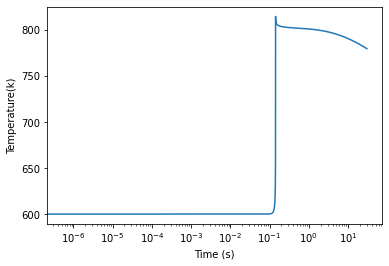

In [12]:
gas.TPX = 600, 101325*40, {'NC7H16':0.5,'IC8H18':0.5, 'O2':0.3} #PRF 50

soln = integrate_gov_eq_validation(hcci,gas,101325*40,300,30.)


plt.semilogx(soln.t,soln.y[1,:])
plt.xlabel('Time (s)')
plt.ylabel('Temperature(k)')

## Input parameters 

In [13]:
N = 2500 # Speed 
dtheta_dt= 2.0*math.pi*N/60.0
cycle=1
thEnd=cycle*720

t0 = 300 # inlet and outlet temp
p0 = 101325 

#PRF 50
gas.TPX = t0, p0, {'NC7H16':0.5,'IC8H18':0.5, 'O2':1} #PRF 50


In [ ]:
soln= integrate_gov_eq(hcci,gas,p0,t0,dtheta_dt,thEnd)